# Style transfer with Cycle-GAN

I got introduced to the concept through Kaggles "[I'm something of a painter myself](https://www.kaggle.com/competitions/gan-getting-started)" competition. Here's my go at it. The architecture of the generator and the descriminator, and the loss function are inspired by [Amy Jang's notebook](https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial/notebook) and [this](https://arxiv.org/pdf/1703.10593.pdf) paper by Zhu et al.

In [ ]:
import tensorflow as tf
!pip install tensorflow_addons
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import os

import matplotlib.pyplot as plt
import numpy as np

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 14.6 MB/s eta 0:00:00


## Preprocessing the images.
Cast to float32, renormalize to $[-1, 1]$, and reshape to $256 \times 256 \times 3$.

In [ ]:
IMAGE_SIZE = [256, 256]

def decode_image(image):
    #image = tf.image.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float32)
    image = (image / tf.reduce_max(image))*2 - 1 ## Scale the image between -1 and 1 (divide by half the max and then - 1)
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

## Download the dataset from `tfds`

In [ ]:
tfds_data = tfds.builder('cycle_gan', config='monet2photo')
tfds_data.download_and_prepare()
monet_ds = tfds_data.as_dataset(split='trainA', shuffle_files=True, batch_size=-1)['image']
photo_ds = tfds_data.as_dataset(split='trainB', shuffle_files=True, batch_size=-1)['image']

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/4 [00:00<?, ? splits/s]

Generating trainA examples...:   0%|          | 0/1072 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cycle_gan/monet2photo/2.0.0.incompletePSK8T8/cycle_gan-trainA.tfrecord*...…

Generating trainB examples...:   0%|          | 0/6287 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cycle_gan/monet2photo/2.0.0.incompletePSK8T8/cycle_gan-trainB.tfrecord*...…

Generating testA examples...:   0%|          | 0/121 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cycle_gan/monet2photo/2.0.0.incompletePSK8T8/cycle_gan-testA.tfrecord*...:…

Generating testB examples...:   0%|          | 0/751 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cycle_gan/monet2photo/2.0.0.incompletePSK8T8/cycle_gan-testB.tfrecord*...:…

Dataset cycle_gan downloaded and prepared to /root/tensorflow_datasets/cycle_gan/monet2photo/2.0.0. Subsequent calls will reuse this data.


## Setup for TPU usage
I didn't use TPU for training but this should take care of the setup. There might be some changes to the training loop as well since this uses the distributed strategy (`strategy.run` , etc.)

In [ ]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
except:
    print("TPU setup failed")
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE
    
print(tf.__version__)

TPU setup failed
Number of replicas: 1
2.9.2


## setup the `Dataset` objects.
This doesn't have to be done exactly like this but the `drop_remainder=True` setting is necessary for XLA and TPU training. Doesn't matter for my case.

In [ ]:
with strategy.scope():
  monet_ds = tf.data.Dataset.from_tensor_slices(monet_ds).map(decode_image).batch(1, drop_remainder=True).prefetch(AUTOTUNE)
  photo_ds = tf.data.Dataset.from_tensor_slices(photo_ds).map(decode_image).batch(1, drop_remainder=True).prefetch(AUTOTUNE)

take one example of each dataset

In [ ]:
example_monet = next(iter(monet_ds))
example_photo = next(iter(photo_ds))

have a look at the examples

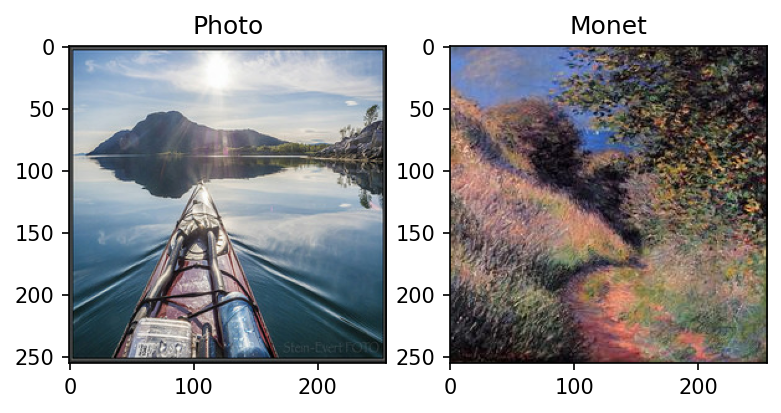

In [ ]:
fig, ax = plt.subplots(1, 2, dpi=150)
ax[0].set_title('Photo')
ax[0].imshow(example_photo[0]*0.5 + 0.5)

ax[1].set_title('Monet')
ax[1].imshow(example_monet[0]*0.5 + 0.5)

## Downsampling unit
A convolution layer followed by instance normalization and a LeakyReLU activation.

In [ ]:
class Downsample(layers.Layer):
    def __init__(self, filters, apply_InstanceNorm=True, **kwargs):
        super(Downsample, self).__init__(**kwargs)
        self.instance_Norm = apply_InstanceNorm
        self.init = tf.random_normal_initializer(mean=0., stddev=0.02)
        self.init_gamma = keras.initializers.RandomNormal(mean=0., stddev=0.02)
        self.conv = layers.Conv2D(filters, 4, strides=2, padding='same',\
                                  use_bias=False, kernel_initializer=self.init)
        self.insNorm = tfa.layers.InstanceNormalization(gamma_initializer=self.init_gamma)
        self.activation = layers.LeakyReLU()
        
    def call(self, inputs):
        x = self.conv(inputs)
        if self.instance_Norm:
            x = self.insNorm(x)
        return self.activation(x)

## Upsampling unit
A transpose convolution unit followed by instance normalization, dropout, and ReLU activation

In [ ]:
class Upsample(layers.Layer):
    def __init__(self, filters, apply_dropout=False, **kwargs):
        super(Upsample, self).__init__(**kwargs)
        self.apply_dropout = apply_dropout
        self.init = tf.random_normal_initializer(mean=0., stddev=0.02)
        self.init_gamma = keras.initializers.RandomNormal(mean=0., stddev=0.02)
        self.conv = layers.Conv2DTranspose(filters, 4, strides=2, padding='same',\
                                  use_bias=False, kernel_initializer=self.init)
        self.insNorm = tfa.layers.InstanceNormalization(gamma_initializer=self.init_gamma)
        self.dropout = layers.Dropout(0.5)
        self.activation = layers.ReLU()
        
    def call(self, inputs):
        x = self.conv(inputs)
        x = self.insNorm(x)
        if self.apply_dropout:
            x = self.dropout(x)
        return self.activation(x)

## The Generator
The Generator is a U-Net with 8 downsample units (64-128-256-512-512-512-512-512-512) and 7 upsampling units (512-512-512-512-256-128-64) connected to a final Conv2DTranspose layer.

In [ ]:
class Generator(keras.models.Model):
    def __init__(self, **kwargs):
        super(Generator, self).__init__(**kwargs)
        self.ds1 = Downsample(64, False)
        self.ds2 = Downsample(128)
        self.ds3 = Downsample(256)
        self.ds4 = Downsample(512)
        self.ds5 = Downsample(512)
        self.ds6 = Downsample(512)
        self.ds7 = Downsample(512)
        self.ds8 = Downsample(512)
        self.us1 = Upsample(512, True)
        self.us2 = Upsample(512, True)
        self.us3 = Upsample(512, True)
        self.us4 = Upsample(512)
        self.us5 = Upsample(256)
        self.us6 = Upsample(128)
        self.us7 = Upsample(64)
        self.final = layers.Conv2DTranspose(3, 4, strides=2, padding='same',
                     kernel_initializer = tf.random_normal_initializer(mean=0., stddev=0.02),
                                           activation='tanh')
        self.concat = layers.Concatenate()
        
    def call(self, inputs):
        x1  = self.ds1(inputs)
        x2  = self.ds2(x1)
        x3  = self.ds3(x2)
        x4  = self.ds4(x3)
        x5  = self.ds5(x4)
        x6  = self.ds6(x5)
        x7  = self.ds7(x6)
        x8  = self.ds8(x7)
        x9  = self.us1(x8)
        x9  = self.concat([x9, x7])
        x10 = self.us2(x9)
        x10 = self.concat([x10, x6])
        x11 = self.us3(x10)
        x11 = self.concat([x11, x5])
        x12 = self.us4(x11)
        x12 = self.concat([x12, x4])
        x13 = self.us5(x12)
        x13 = self.concat([x13, x3])
        x14 = self.us6(x13)
        x14 = self.concat([x14, x2])
        x15 = self.us7(x14)
        x15 = self.concat([x15, x1])
        out = self.final(x15)
        return out            

## The Discriminator
Simple Discriminator with 3 downsample units and 2 convolution layers. The output is a $30 \times 30 \times 1$ patch instead of a single number.

In [ ]:
class Discriminator(keras.models.Model):
    def __init__(self, **kwargs):
        super(Discriminator, self).__init__(**kwargs)
        self.ds1 = Downsample(64, False)
        self.ds2 = Downsample(128)
        self.ds3 = Downsample(256)
        self.zeropad = layers.ZeroPadding2D()
        self.conv = layers.Conv2D(512, 4, strides=1, 
                    kernel_initializer = tf.random_normal_initializer(mean=0., stddev=0.02),
                                 use_bias=False)
        self.norm = tfa.layers.InstanceNormalization(
            gamma_initializer = keras.initializers.RandomNormal(mean=0., stddev=0.02))
        self.activation = layers.LeakyReLU()
        self.final = layers.Conv2D(1, 4, strides=1, 
                     kernel_initializer = tf.random_normal_initializer(mean=0., stddev=0.02))
        
    def call(self, inputs):
        x = self.ds1(inputs)
        x = self.ds2(x)
        x = self.ds3(x)
        x = self.zeropad(x)
        x = self.conv(x)
        x = self.norm(x)
        x = self.activation(x)
        x = self.zeropad(x)
        x = self.final(x)
        return x

## Compelete CycleGAN object
There are 2 generators, one for making real photos look like monet and the other for making monet painting look like real photos.

There are 2 discriminators as well, one for each generator.

There are 4 losses defined here:
1. Descriminator loss: Did the discriminator succesfully determined whether the input was fake or real?
2. Generator loss: Did the generator succesfully fool the discriminator into thinking the image it generated was real?
3. Cycle loss: 

real $\to$ `monet_gen` $\to$ fake_monet $\to$ `real_gen` $\to$ real

and

monet $\to$ `real_gen` $\to$ fake_real $\to$ `real_gen` $\to$ monet
Basically, an input going around the cycle should come out as itself.
4. Identity loss:

monet $\to$ `monet_gen` $\to$ monet 

real $\to$ `real_gen` $\to$ real

Overall loss is the sum of these.


In [ ]:
class CycleGAN(keras.models.Model):
    def __init__(self, **kwargs):
        super(CycleGAN, self).__init__(**kwargs)
        self.monet_gen = Generator()
        self.photo_gen = Generator()
        self.monet_dsc = Discriminator()
        self.photo_dsc = Discriminator()
        self.monet_gen_optimizer = keras.optimizers.Adam(2e-4, beta_1=0.5)
        self.photo_gen_optimizer = keras.optimizers.Adam(2e-4, beta_1=0.5)
        self.monet_dsc_optimizer = keras.optimizers.Adam(2e-4, beta_1=0.5)
        self.photo_dsc_optimizer = keras.optimizers.Adam(2e-4, beta_1=0.5)
    
    def dsc_loss(self, real, generated):
        real_loss = keras.losses.BinaryCrossentropy(from_logits=True,
                    reduction=keras.losses.Reduction.NONE)(tf.ones_like(real), real)
        fake_loss = keras.losses.BinaryCrossentropy(from_logits=True,
                    reduction=keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)
        return real_loss + fake_loss
    
    def gen_loss(self, generated):
        return keras.losses.BinaryCrossentropy(from_logits=True, 
               reduction=keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)
    
    def cycle_loss(self, real, cycled, lam=10):
        return lam * tf.reduce_mean(tf.abs(real - cycled))
    
    def identity_loss(self, real, same, lam=10):
        return lam * 0.5 * tf.reduce_mean(tf.abs(real - same))
    
    def train_step(self, batch):
        photo, monet = batch
        with tf.GradientTape(persistent=True) as tape:
            fake_monet = self.monet_gen(photo)
            cycled_photo = self.photo_gen(fake_monet)
            
            fake_photo = self.photo_gen(monet)
            cycled_monet = self.monet_gen(fake_photo)
            
            same_photo = self.photo_gen(photo)
            same_monet = self.monet_gen(monet)
            
            disc_real_monet = self.monet_dsc(monet)
            disc_real_photo = self.photo_dsc(photo)
            
            disc_fake_monet = self.monet_dsc(fake_monet)
            disc_fake_photo = self.photo_dsc(fake_photo)
            
            monet_dsc_loss = self.dsc_loss(disc_real_monet, disc_fake_monet)
            photo_dsc_loss = self.dsc_loss(disc_real_photo, disc_fake_photo)
            
            total_cycle_loss = self.cycle_loss(monet, cycled_monet) + self.cycle_loss(photo, cycled_photo)
            
            monet_gen_loss = self.gen_loss(disc_fake_monet) + total_cycle_loss +\
            self.identity_loss(monet, same_monet)
            
            photo_gen_loss = self.gen_loss(disc_fake_photo) + total_cycle_loss +\
            self.identity_loss(photo, same_photo)
            
        m_gen_grad = tape.gradient(monet_gen_loss, self.monet_gen.trainable_variables)
        m_dsc_grad = tape.gradient(monet_dsc_loss, self.monet_dsc.trainable_variables)
        p_gen_grad = tape.gradient(photo_gen_loss, self.photo_gen.trainable_variables)
        p_dsc_grad = tape.gradient(photo_dsc_loss, self.photo_dsc.trainable_variables)
        
        self.monet_gen_optimizer.apply_gradients(zip(m_gen_grad, self.monet_gen.trainable_variables))
        self.monet_dsc_optimizer.apply_gradients(zip(m_dsc_grad, self.monet_dsc.trainable_variables))    
        self.photo_gen_optimizer.apply_gradients(zip(p_gen_grad, self.photo_gen.trainable_variables))    
        self.photo_dsc_optimizer.apply_gradients(zip(p_dsc_grad, self.photo_dsc.trainable_variables))
        
        return {
            "m_gen_loss": monet_gen_loss,
            "p_gen_loss": photo_gen_loss,
            "m_dsc_loss": monet_dsc_loss,
            "p_dsc_loss": photo_dsc_loss,
        }
        
    def train(self, ds, epochs):
        for epoch in range(epochs):
            for data in ds:
                losses = self.train_step(data)
            tf.print(f"""epoch: {epoch},\t m_gen loss: {tf.reduce_mean(losses["m_gen_loss"])},\t p_gen loss: {tf.reduce_mean(losses["p_gen_loss"])}, m_dsc loss: {tf.reduce_mean(losses["m_dsc_loss"])}, p_dsc loss: {tf.reduce_mean(losses["p_dsc_loss"])}""")
            
        return None

                
        

Create the object and test an input

In [ ]:
with strategy.scope():
    cycle_gan_model = CycleGAN()
test_monet = cycle_gan_model.monet_gen(example_photo)

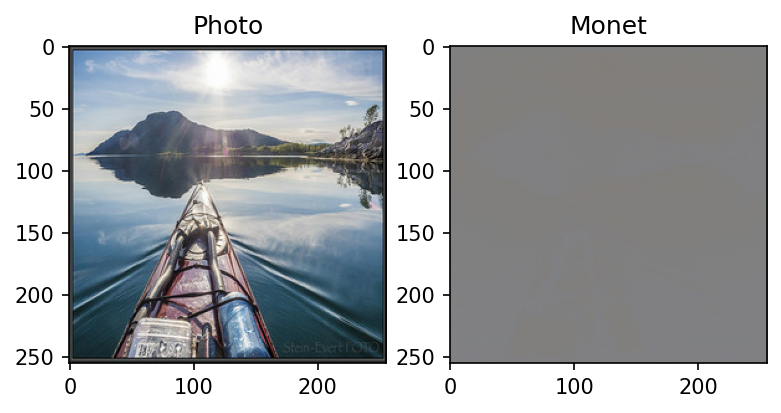

In [ ]:
fig, ax = plt.subplots(1, 2, dpi=150)
ax[0].set_title('Photo')
ax[0].imshow(example_photo[0]*0.5 + 0.5)

ax[1].set_title('Monet')
ax[1].imshow(test_monet[0]*0.5 + 0.5)

Outputs noise because it has random weights before training.

## Train
Train CycleGAN for 10 epochs. Notice the two datasets are zipped and passed to the model. It doesn't matter which two pair of photo/monet are passed at each epoch as long as the same ones don't get passed in. Also the batch size for both data sets is 1 so each epoch is just one pair of photos.

In [ ]:
with strategy.scope():
  cycle_gan_model = CycleGAN()
  cycle_gan_model.train(
        tf.data.Dataset.zip((photo_ds, monet_ds)),
        epochs=10
    )

epoch: 0,	 m_gen loss: 4.036203384399414,	 p_gen loss: 5.0994553565979, m_dsc loss: 1.2989656925201416, p_dsc loss: 0.791059136390686
epoch: 1,	 m_gen loss: 3.5121445655822754,	 p_gen loss: 4.297967433929443, m_dsc loss: 1.546463131904602, p_dsc loss: 1.2357348203659058
epoch: 2,	 m_gen loss: 3.261470079421997,	 p_gen loss: 4.106157302856445, m_dsc loss: 1.4388259649276733, p_dsc loss: 1.1355243921279907
epoch: 3,	 m_gen loss: 3.1116626262664795,	 p_gen loss: 3.7555954456329346, m_dsc loss: 1.3309767246246338, p_dsc loss: 1.3365322351455688
epoch: 4,	 m_gen loss: 2.8883275985717773,	 p_gen loss: 3.7058777809143066, m_dsc loss: 1.2498728036880493, p_dsc loss: 1.317004680633545
epoch: 5,	 m_gen loss: 2.8293566703796387,	 p_gen loss: 3.718421697616577, m_dsc loss: 1.2094194889068604, p_dsc loss: 1.297163724899292
epoch: 6,	 m_gen loss: 2.8371212482452393,	 p_gen loss: 3.633399486541748, m_dsc loss: 1.1624222993850708, p_dsc loss: 1.247989535331726
epoch: 7,	 m_gen loss: 2.814274311065674,

I couldn't afford to train for longer but 10 epochs already shows improvements

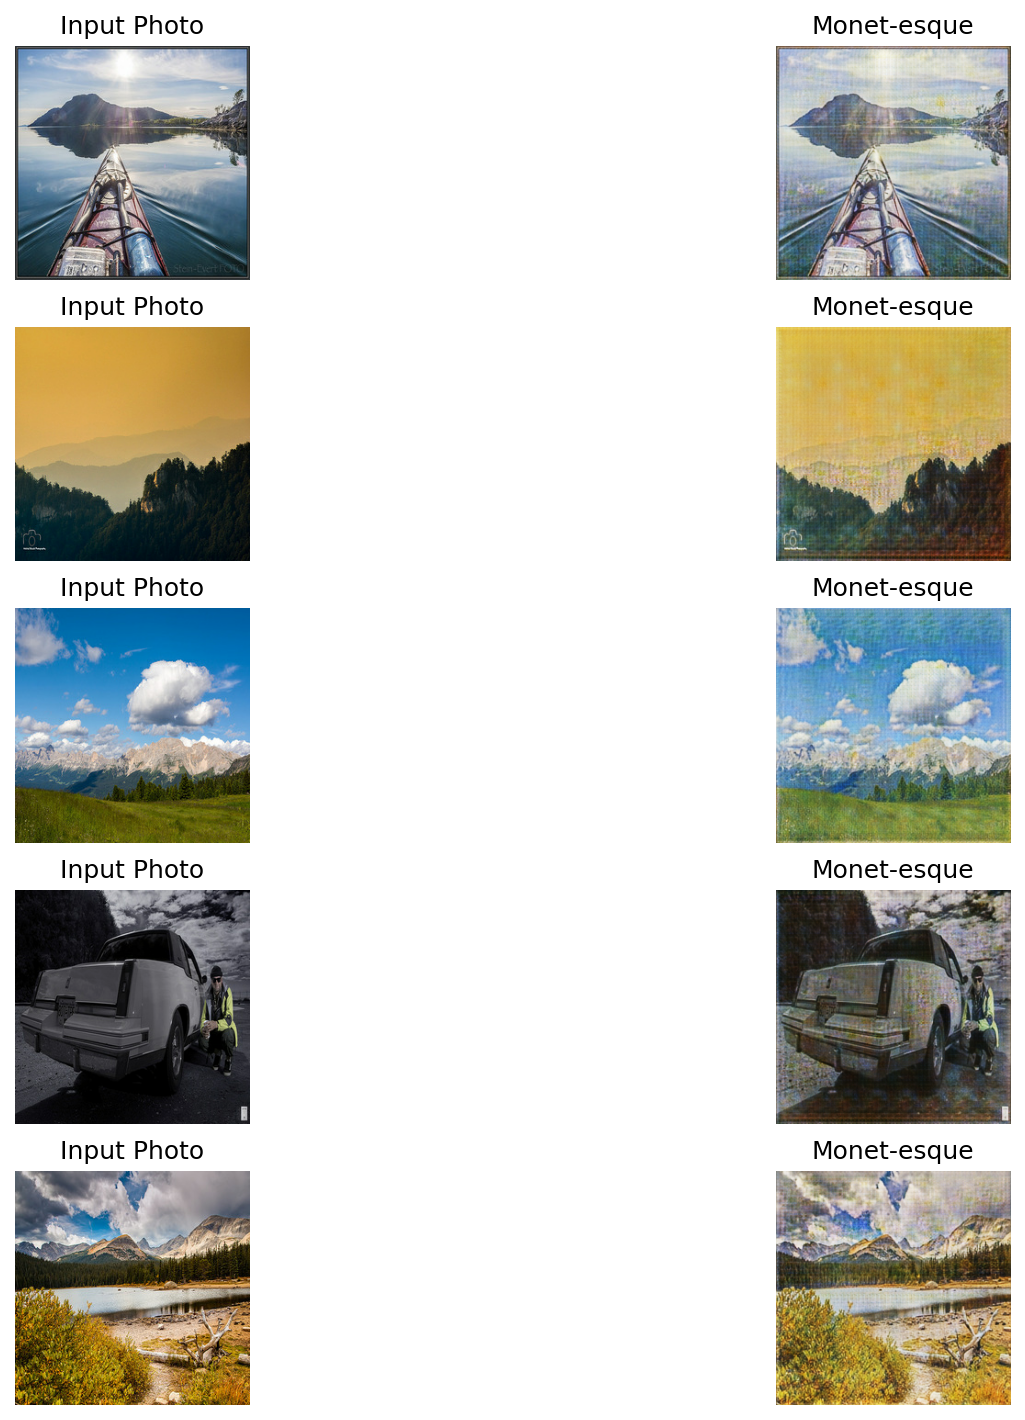

In [ ]:
_, ax = plt.subplots(5, 2, figsize=(12, 12), dpi=150)
for i, img in enumerate(photo_ds.take(5)):
    prediction = cycle_gan_model.monet_gen(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

You can see the texture added on top of the pictures here to make them look more like a painting! More training steps should give better results too!